# Import needed libraries
To make things work ensure that you have this libraries installed.

In [3]:
# imports
import os
import splitfolders
import tensorflow as tf
from typing import Tuple, List
from string import digits
from imutils import paths
from random import choices
from tensorflow.data import AUTOTUNE
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Bidirectional, InputLayer, Reshape
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
import seaborn as sns
from tqdm import tqdm

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [4]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Data
The Dataset class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [5]:
class Dataset:

    MAX_IMAGES_PER_GENRE = 5_000
    
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, split_folders: bool = False, image_size: Tuple[int, int] = (224,224), batch_size: int = 8 , cache: bool = True):
        assert sum(ratio) == 1.0

        self.path = path
        self.labels = [name for name in tqdm(os.listdir(self.path)) if os.path.isdir(os.path.join(self.path, name))]
        
        self.cache = cache
        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        assert split == True or split_folders == True or output is not None
        
        if split:
            self.__split()
        elif split_folders:
            self.__split_folder()
            
        self.__generate()
    
    def __split(self):
        tmp_ratio = (1.0 - self.ratio[0])
        val_test_ratio = self.ratio[1] / tmp_ratio
        
        def get_genres(path):
            genres = {}
            for image_path in tqdm(list(paths.list_images(path))):
                genre = os.path.basename(os.path.dirname(image_path))

                if genre not in genres:
                    genres[genre] = []
                
                if len(genres[genre]) >= Dataset.MAX_IMAGES_PER_GENRE:
                    continue
                
                genres[genre].append(image_path)
            
            return genres

        
        def split_genre(genre):
            train, tmp = train_test_split(genre, test_size=tmp_ratio, random_state=42)
            test, val = train_test_split(tmp, test_size=val_test_ratio, random_state=42)
            
            return train, val, test
        
        self.train, self.val, self.test = [], [], []
        genres = get_genres(self.path)
        for genre in genres.values():
            train, val, test = split_genre(genre)
            self.train.extend(train)
            self.val.extend(val)
            self.test.extend(test)
    
        np.random.shuffle(self.train)
        np.random.shuffle(self.val)
        np.random.shuffle(self.test)
    
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def __generate(self):
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            image = tf.keras.applications.xception.preprocess_input(image)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        def get_paths(x):
            if isinstance(x, str):
                return paths.list_images(x)
            else:
                return x
        
        train_paths = get_paths(self.train)
        self.train_len = len(train_paths) // self.batch_size
        self.train = tf.data.Dataset.from_tensor_slices(train_paths)
        self.train = (self.train
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.train = self.train.cache()
        
        val_paths = get_paths(self.val)
        self.val_len = len(val_paths) // self.batch_size
        self.val = tf.data.Dataset.from_tensor_slices(val_paths)
        self.val = (self.val
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.val = val.train.cache()
        
        test_paths = get_paths(self.test)
        self.test_len = len(test_paths) // self.batch_size
        self.test = tf.data.Dataset.from_tensor_slices(test_paths)
        self.test = (self.test
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.test = self.test.cache()

# Xception
The *build_model* method is used to build model based on [Xception network](https://arxiv.org/abs/1610.02357) with added custom dense layers. The **STFT** and **Mel Spectrogram** are used to learn this model.

In [30]:
def build_model(height: int = 224, width: int = 224, channels: int = 3):
    input_shape = (channels, height, width) if  K.image_data_format() == 'channels_first' else (height, width, channels)
    
    # Create the model
    model = Sequential()
    model.add(tf.keras.applications.Xception(include_top=False,
                                           weights=None,
                                           input_shape=input_shape,
                                           pooling='max'))
#     model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name='accuracy')
        ])
    
    return model

# Short-Time Fourier Transform

In [31]:
model = build_model()

In [32]:
batch_size = 8
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size)

Copying files: 4995 files [00:10, 459.66 files/s]


In [ ]:
epochs = 20
batch_size = 8

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len // 8,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len // 8,
                    verbose=1)

Epoch 1/20
  1/437 ━━━━━━━━━━━━━━━━━━━━ 4:48:23 40s/step - accuracy: 0.0000e+00 - loss: 2.6075

W0000 00:00:1712744114.262158     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3584 - loss: 1.7962

W0000 00:00:1712744168.977073      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 97s 132ms/step - accuracy: 0.3586 - loss: 1.7955 - val_accuracy: 0.1841 - val_loss: 2.3304
Epoch 2/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7599 - loss: 0.7145

W0000 00:00:1712744223.098426     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 54s 124ms/step - accuracy: 0.7601 - loss: 0.7140 - val_accuracy: 0.5897 - val_loss: 1.1575
Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9941 - loss: 0.0766 - val_accuracy: 0.7206 - val_loss: 0.9067
Epoch 4/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9995 - loss: 0.0172 - val_accuracy: 0.7652 - val_loss: 0.7874
Epoch 5/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9996 - loss: 0.0094 - val_accuracy: 0.7112 - val_loss: 0.9953
Epoch 6/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9997 - loss: 0.0087 - val_accuracy: 0.7638 - val_loss: 0.7893
Epoch 7/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9997 - loss: 0.0088 - val_accuracy: 0.7557 - val_loss: 0.8210
Epoch 8/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9987 - loss: 0.0129 - val_accuracy: 0.4710 - val_loss: 2.2173
Epoch 9/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.6728 - loss: 0.9902 - val

In [ ]:
plot_history(history, metric='accuracy')

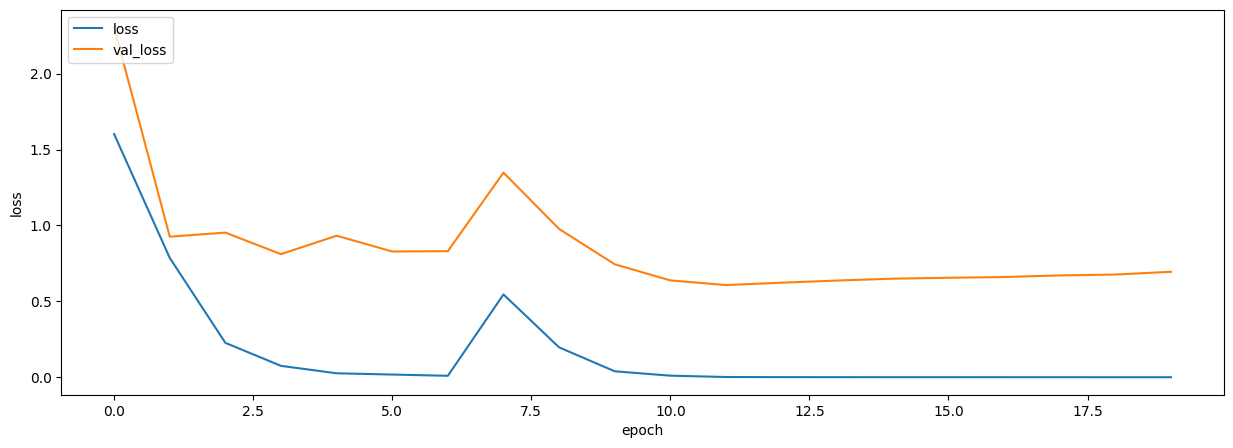

In [16]:
plot_history(history, metric='loss')

In [19]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8227 - loss: 0.6273
Accuracy: 0.8453333377838135
Loss: 0.563007652759552


W0000 00:00:1712742678.620513     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


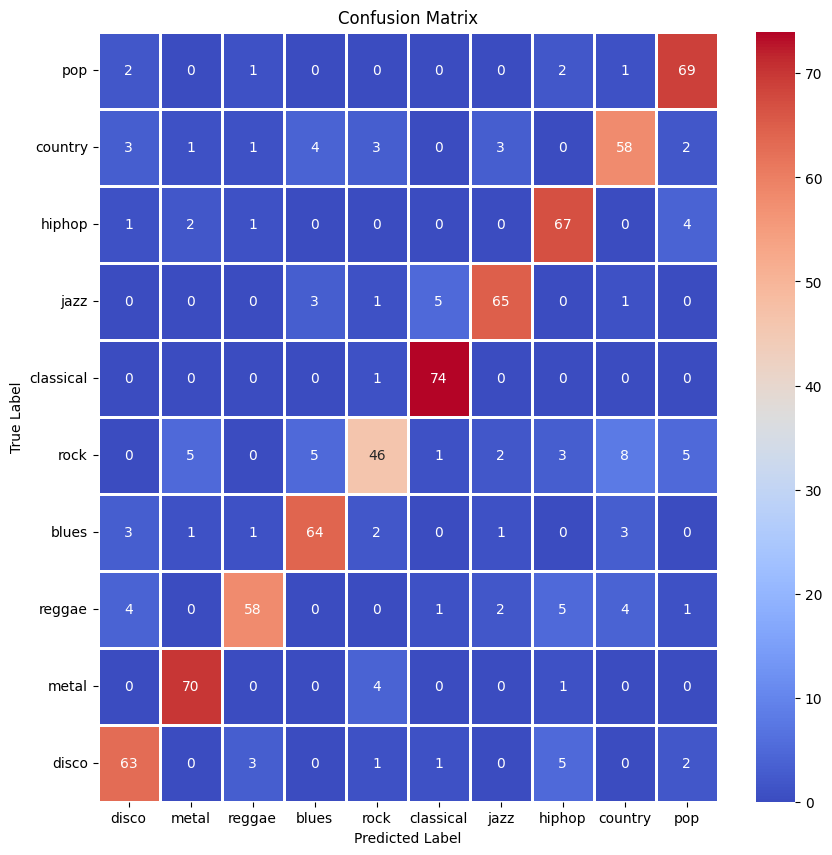

              precision    recall  f1-score   support

           0       0.83      0.84      0.83        75
           1       0.89      0.93      0.91        75
           2       0.89      0.77      0.83        75
           3       0.84      0.85      0.85        75
           4       0.79      0.61      0.69        75
           5       0.90      0.99      0.94        75
           6       0.89      0.87      0.88        75
           7       0.81      0.89      0.85        75
           8       0.77      0.77      0.77        75
           9       0.83      0.92      0.87        75

    accuracy                           0.85       750
   macro avg       0.84      0.85      0.84       750
weighted avg       0.84      0.85      0.84       750



In [22]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# Mel Spectogram

In [23]:
batch_size = 8
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size)

Copying files: 4995 files [00:39, 125.04 files/s]


In [24]:
model = build_model()

epochs = 20
batch_size = 8

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len // 8,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len // 8,
                    verbose=1)

Epoch 1/20
  1/437 ━━━━━━━━━━━━━━━━━━━━ 4:48:05 40s/step - accuracy: 0.0000e+00 - loss: 3.9266

W0000 00:00:1712742818.219252      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3153 - loss: 1.9255

W0000 00:00:1712742872.029082     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 96s 130ms/step - accuracy: 0.3155 - loss: 1.9249 - val_accuracy: 0.1640 - val_loss: 2.3084
Epoch 2/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6039 - loss: 1.1185

W0000 00:00:1712742925.647737     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 53s 122ms/step - accuracy: 0.6040 - loss: 1.1182 - val_accuracy: 0.5938 - val_loss: 1.1604
Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.8429 - loss: 0.5411 - val_accuracy: 0.6788 - val_loss: 0.9866
Epoch 4/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9751 - loss: 0.1439 - val_accuracy: 0.6559 - val_loss: 1.1343
Epoch 5/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9945 - loss: 0.0596 - val_accuracy: 0.6883 - val_loss: 0.9895
Epoch 6/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9951 - loss: 0.0349 - val_accuracy: 0.7341 - val_loss: 0.8749
Epoch 7/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9977 - loss: 0.0129 - val_accuracy: 0.7665 - val_loss: 0.7971
Epoch 8/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9948 - loss: 0.0208 - val_accuracy: 0.3482 - val_loss: 3.9723
Epoch 9/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.7152 - loss: 0.8498 - val

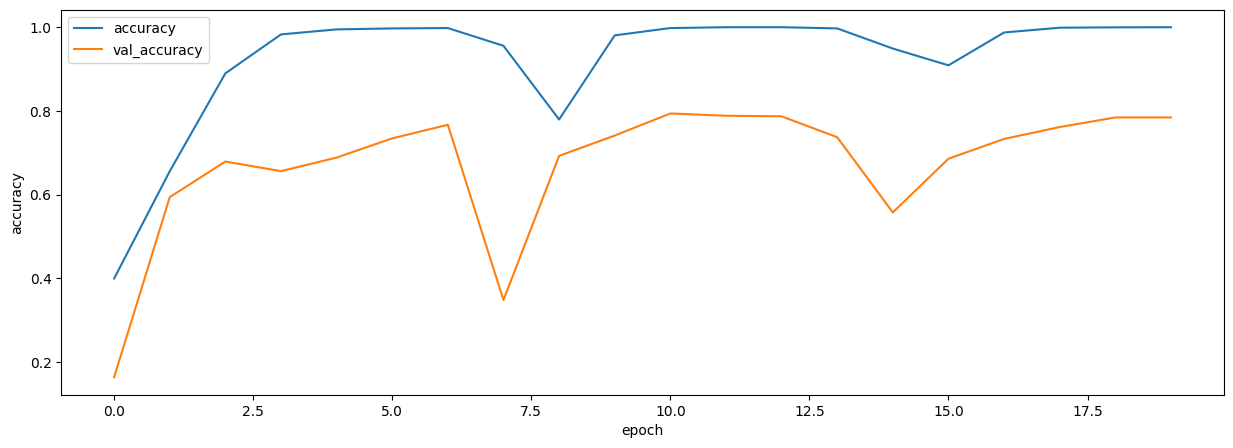

In [25]:
plot_history(history, metric='accuracy')

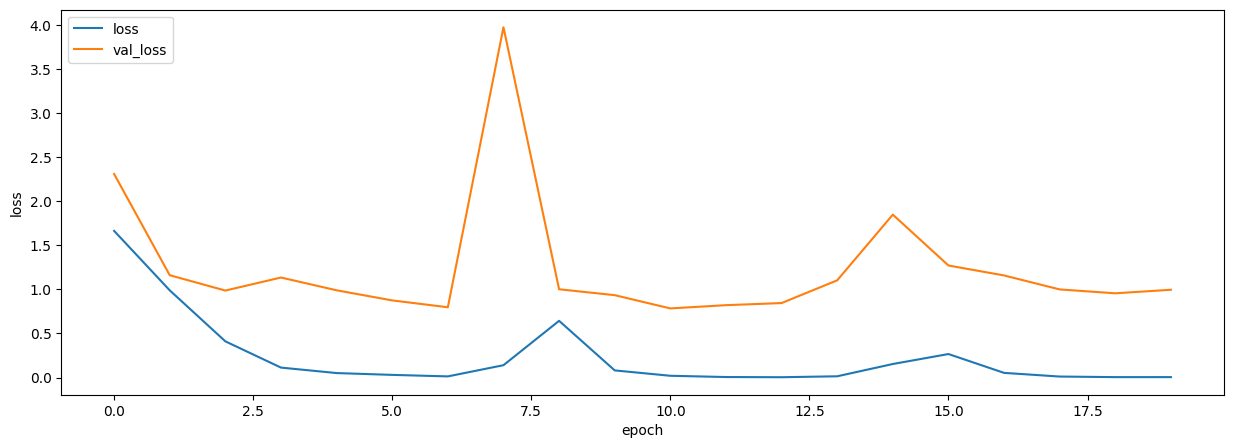

In [26]:
plot_history(history, metric='loss')

In [27]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7904 - loss: 0.7414
Accuracy: 0.8133333325386047
Loss: 0.7304238677024841


W0000 00:00:1712743933.820445     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 5/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step

W0000 00:00:1712743951.057706     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step


W0000 00:00:1712743956.392257     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


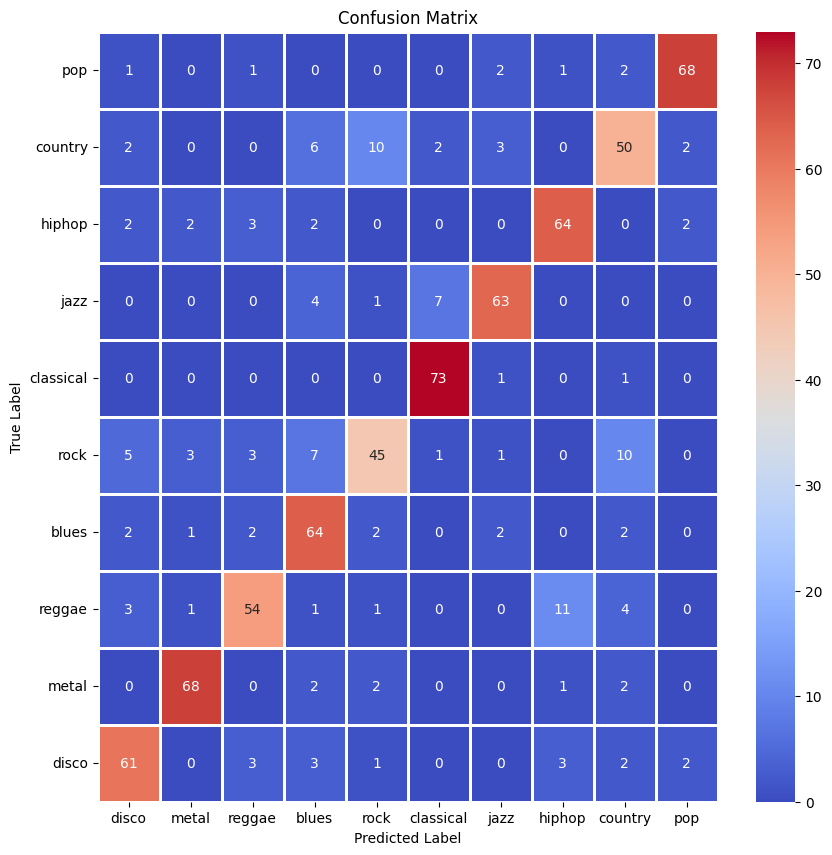

              precision    recall  f1-score   support

           0       0.80      0.81      0.81        75
           1       0.91      0.91      0.91        75
           2       0.82      0.72      0.77        75
           3       0.72      0.85      0.78        75
           4       0.73      0.60      0.66        75
           5       0.88      0.97      0.92        75
           6       0.88      0.84      0.86        75
           7       0.80      0.85      0.83        75
           8       0.68      0.67      0.68        75
           9       0.92      0.91      0.91        75

    accuracy                           0.81       750
   macro avg       0.81      0.81      0.81       750
weighted avg       0.81      0.81      0.81       750



In [29]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# FMA

## Model
This model differs from first one by disabling learning of pretrained layers.

In [6]:
def build_model(height: int = 224, width: int = 224, channels: int = 3):
    input_shape = (channels, height, width) if  K.image_data_format() == 'channels_first' else (height, width, channels)
    
    # Create the model
    model = Sequential()
    base = tf.keras.applications.Xception(include_top=False,
                                           weights='imagenet',
                                           input_shape=input_shape,
                                           pooling='max')
    n_trainable = 6
    for layer in base.layers[:133-n_trainable]:
        layer.trainable = False

    for layer in base.layers[133-n_trainable:133]:
        layer.trainable = True
    model.add(base)
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(15, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name='accuracy')
        ])
    
    return model

## STFT

In [7]:
batch_size = 64
dataset = Dataset(path='/kaggle/input/fma-images/stft/stft', batch_size=batch_size, cache=False)

100%|██████████| 64846/64846 [00:00<00:00, 276136.10it/s]


In [25]:
model = build_model()

epochs = 10

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/10


W0000 00:00:1714823599.152930     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.2170 - loss: 2.3032

W0000 00:00:1714823747.500891     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 186s 315ms/step - accuracy: 0.2172 - loss: 2.3029 - val_accuracy: 0.3290 - val_loss: 2.0005
Epoch 2/10


W0000 00:00:1714823779.439232     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.3783 - loss: 1.8795

W0000 00:00:1714823925.700716     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 178s 312ms/step - accuracy: 0.3783 - loss: 1.8794 - val_accuracy: 0.3643 - val_loss: 1.9069
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 174s 309ms/step - accuracy: 0.4142 - loss: 1.7649 - val_accuracy: 0.3654 - val_loss: 1.9242
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 174s 309ms/step - accuracy: 0.4351 - loss: 1.7139 - val_accuracy: 0.3966 - val_loss: 1.8782
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 309ms/step - accuracy: 0.4471 - loss: 1.6742 - val_accuracy: 0.4434 - val_loss: 1.6786
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 308ms/step - accuracy: 0.4520 - loss: 1.6494 - val_accuracy: 0.4204 - val_loss: 1.7260
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 308ms/step - accuracy: 0.4637 - loss: 1.6277 - val_accuracy: 0.4506 - val_loss: 1.6770
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 309ms/step - accuracy: 0.4752 - loss: 1.5851 - val_accuracy: 0.4684 - val_loss: 1.6122
Epoch 9/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 309ms/step - accuracy: 0.4886 - loss: 1.54

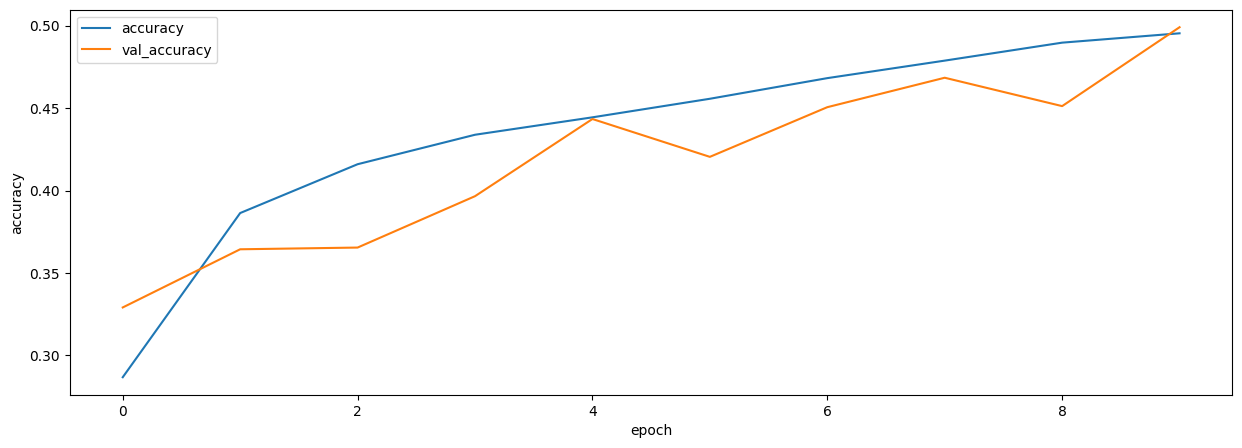

In [26]:
plot_history(history, metric='accuracy')

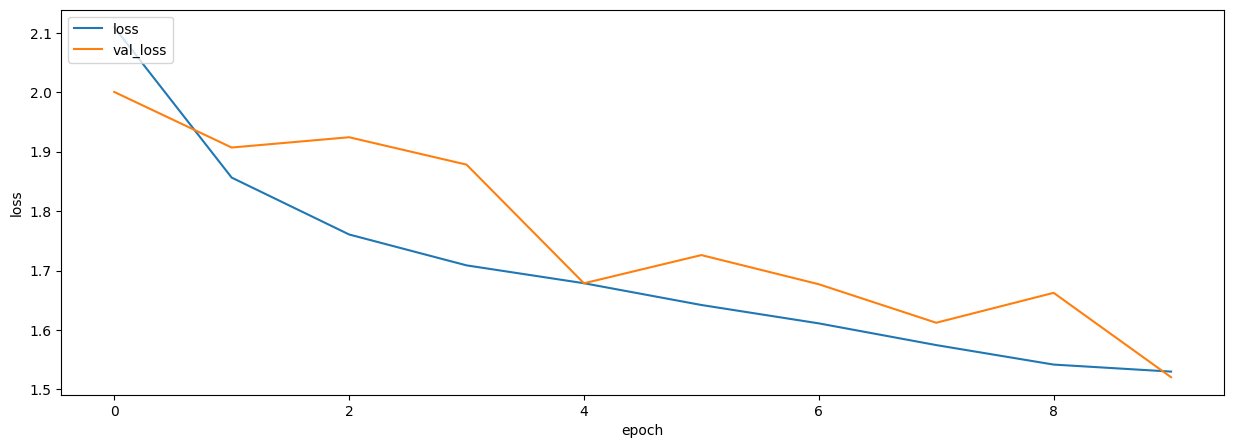

In [27]:
plot_history(history, metric='loss')

In [28]:
epochs = 5
    
model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name='accuracy')
        ])
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/5


W0000 00:00:1714825351.301367     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5193 - loss: 1.4519

W0000 00:00:1714825499.254180     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 186s 315ms/step - accuracy: 0.5194 - loss: 1.4519 - val_accuracy: 0.4944 - val_loss: 1.5627
Epoch 2/5
  1/562 ━━━━━━━━━━━━━━━━━━━━ 31:13 3s/step - accuracy: 0.5333 - loss: 1.5011

W0000 00:00:1714825531.396800     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.5368 - loss: 1.4028

W0000 00:00:1714825677.401510     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 178s 311ms/step - accuracy: 0.5368 - loss: 1.4028 - val_accuracy: 0.5059 - val_loss: 1.4967
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 309ms/step - accuracy: 0.5348 - loss: 1.3959 - val_accuracy: 0.5108 - val_loss: 1.4941
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 308ms/step - accuracy: 0.5432 - loss: 1.3725 - val_accuracy: 0.5262 - val_loss: 1.4452
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 174s 309ms/step - accuracy: 0.5585 - loss: 1.3388 - val_accuracy: 0.5398 - val_loss: 1.4102


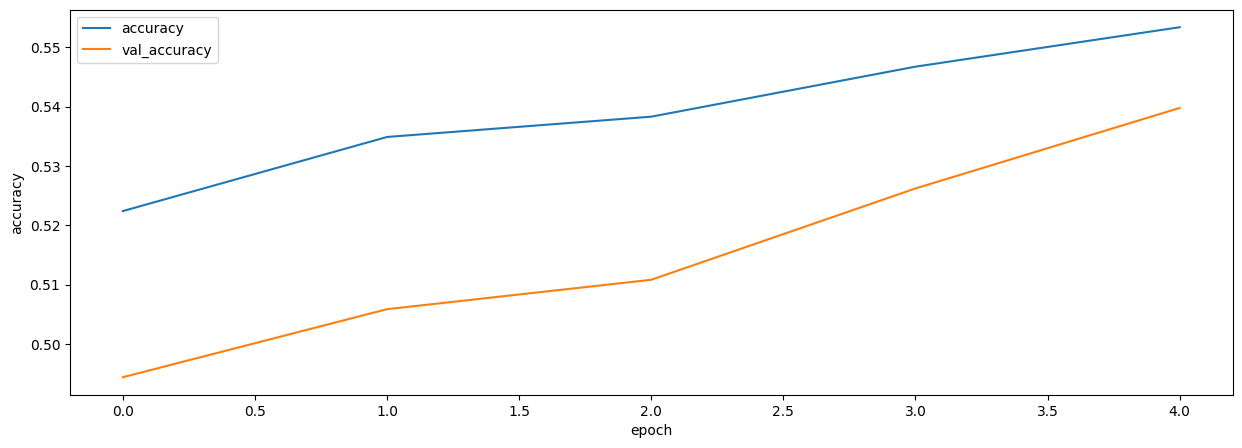

In [29]:
plot_history(history, metric='accuracy')

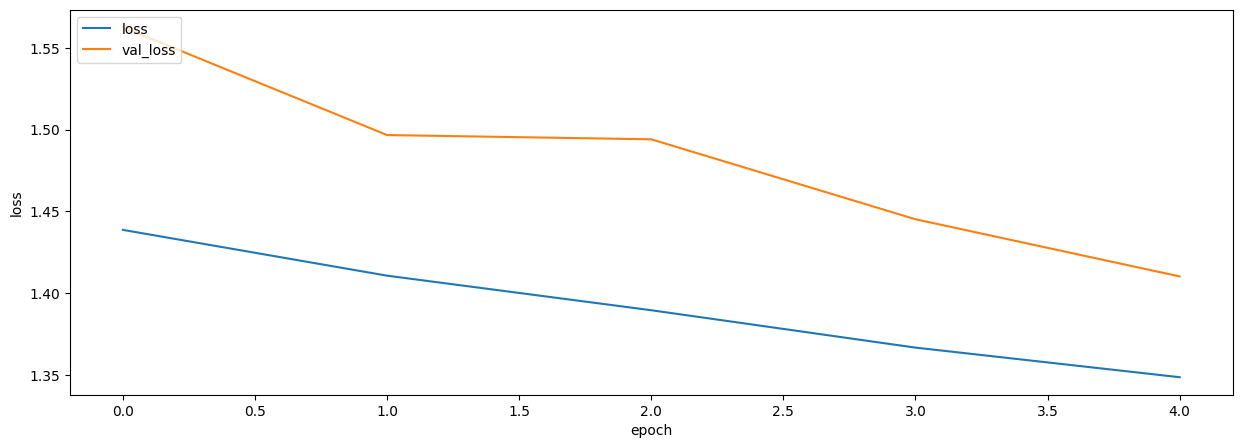

In [30]:
plot_history(history, metric='loss')

In [31]:
epochs = 5
model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name='accuracy')
        ])
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/5


W0000 00:00:1714826236.917232     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5695 - loss: 1.2879

W0000 00:00:1714826384.899424     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 187s 315ms/step - accuracy: 0.5695 - loss: 1.2878 - val_accuracy: 0.5482 - val_loss: 1.3833
Epoch 2/5


W0000 00:00:1714826416.935762     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.5822 - loss: 1.2561

W0000 00:00:1714826563.297330     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 178s 312ms/step - accuracy: 0.5822 - loss: 1.2561 - val_accuracy: 0.5513 - val_loss: 1.3680
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 309ms/step - accuracy: 0.5850 - loss: 1.2479 - val_accuracy: 0.5474 - val_loss: 1.3734
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 308ms/step - accuracy: 0.5876 - loss: 1.2419 - val_accuracy: 0.5550 - val_loss: 1.3578
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 308ms/step - accuracy: 0.5893 - loss: 1.2325 - val_accuracy: 0.5504 - val_loss: 1.3829


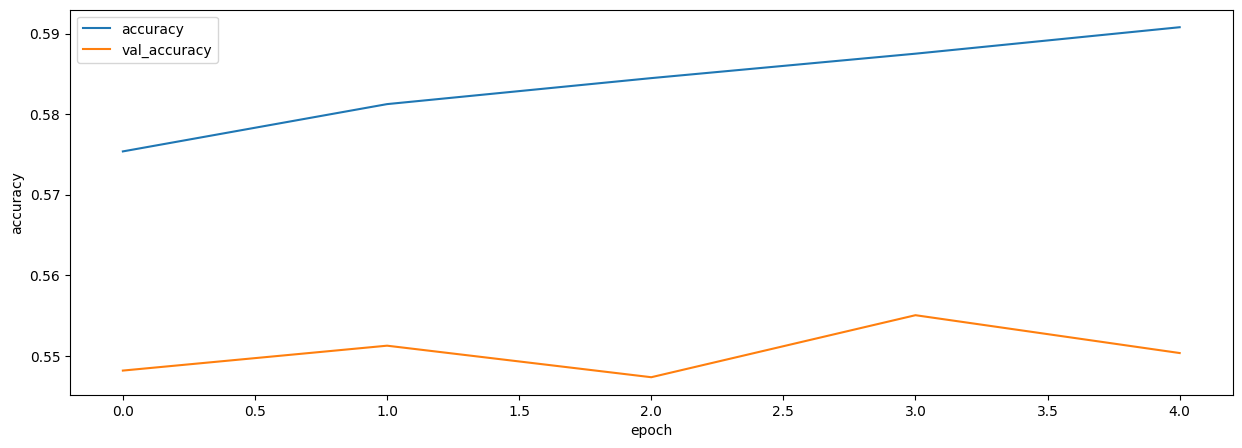

In [32]:
plot_history(history, metric='accuracy')

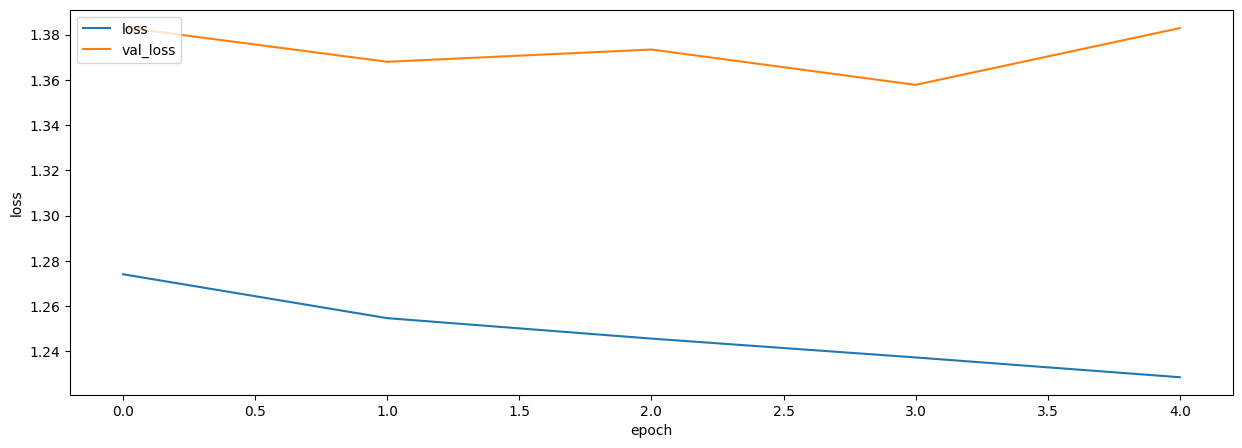

In [33]:
plot_history(history, metric='loss')

In [34]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

121/121 ━━━━━━━━━━━━━━━━━━━━ 50s 416ms/step - accuracy: 0.5497 - loss: 1.3794
Accuracy: 0.5473384261131287
Loss: 1.3644325733184814


W0000 00:00:1714827251.830267     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  1/121 ━━━━━━━━━━━━━━━━━━━━ 6:02 3s/step

W0000 00:00:1714827258.136803     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


121/121 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step


W0000 00:00:1714827288.920782     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


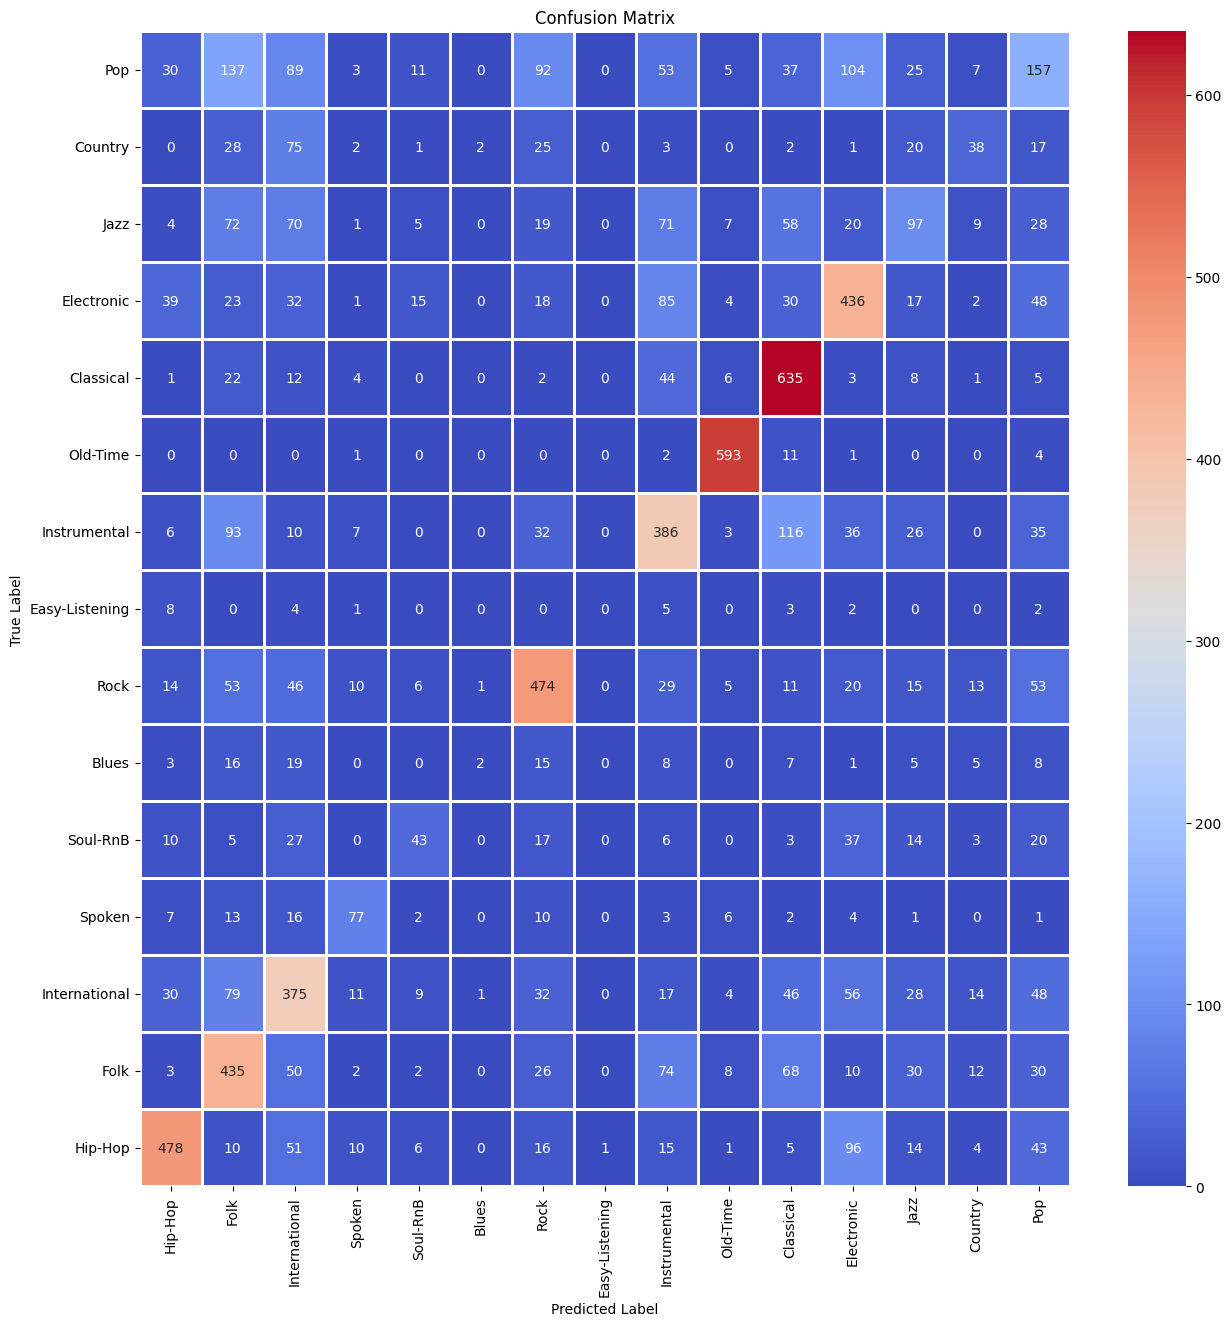

              precision    recall  f1-score   support

           0       0.76      0.64      0.69       750
           1       0.44      0.58      0.50       750
           2       0.43      0.50      0.46       750
           3       0.59      0.54      0.57       142
           4       0.43      0.23      0.30       185
           5       0.33      0.02      0.04        89
           6       0.61      0.63      0.62       750
           7       0.00      0.00      0.00        25
           8       0.48      0.51      0.50       750
           9       0.92      0.97      0.95       612
          10       0.61      0.85      0.71       743
          11       0.53      0.58      0.55       750
          12       0.32      0.21      0.25       461
          13       0.35      0.18      0.24       214
          14       0.31      0.21      0.25       750

    accuracy                           0.55      7721
   macro avg       0.48      0.44      0.44      7721
weighted avg       0.53   

In [35]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

## Mel-Spectrogram

In [8]:
batch_size = 64
dataset = Dataset(path='/kaggle/input/fma-images/mel/mel', batch_size=batch_size, cache=False)

100%|██████████| 64842/64842 [00:00<00:00, 274909.14it/s]


In [9]:
model = build_model()

epochs = 10

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10


I0000 00:00:1714829027.583530     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714829027.623713     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.2105 - loss: 2.3257

W0000 00:00:1714829162.870602     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 201s 288ms/step - accuracy: 0.2107 - loss: 2.3254 - val_accuracy: 0.3625 - val_loss: 1.9525
Epoch 2/10
  1/562 ━━━━━━━━━━━━━━━━━━━━ 3:51:51 25s/step - accuracy: 0.3409 - loss: 1.9640

W0000 00:00:1714829214.132075     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.3859 - loss: 1.8682

W0000 00:00:1714829369.534938     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 206s 324ms/step - accuracy: 0.3859 - loss: 1.8681 - val_accuracy: 0.4109 - val_loss: 1.8034
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 284ms/step - accuracy: 0.4082 - loss: 1.7950 - val_accuracy: 0.3744 - val_loss: 1.8875
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 284ms/step - accuracy: 0.4233 - loss: 1.7528 - val_accuracy: 0.4483 - val_loss: 1.6937
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 285ms/step - accuracy: 0.4418 - loss: 1.6982 - val_accuracy: 0.4540 - val_loss: 1.6769
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 285ms/step - accuracy: 0.4468 - loss: 1.6788 - val_accuracy: 0.4429 - val_loss: 1.6981
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 285ms/step - accuracy: 0.4632 - loss: 1.6453 - val_accuracy: 0.4323 - val_loss: 1.7321
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 285ms/step - accuracy: 0.4647 - loss: 1.6225 - val_accuracy: 0.4416 - val_loss: 1.6889
Epoch 9/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 285ms/step - accuracy: 0.4710 - loss: 1.59

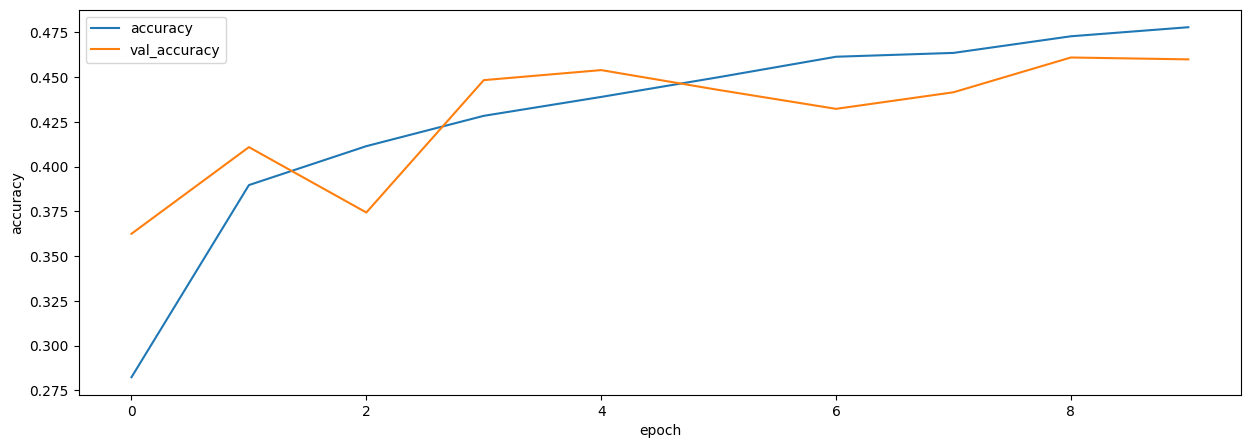

In [10]:
plot_history(history, metric='accuracy')

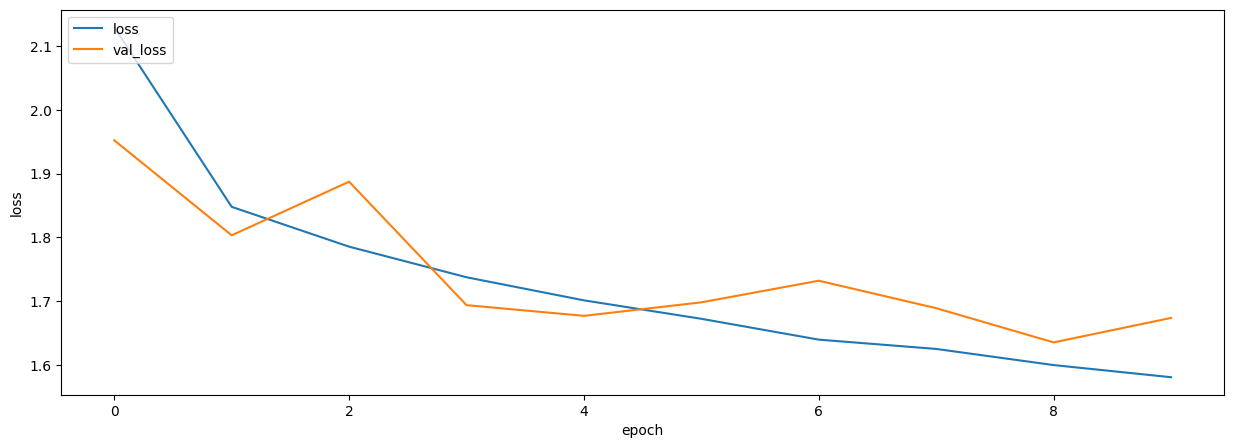

In [11]:
plot_history(history, metric='loss')

In [12]:
epochs = 5
model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name='accuracy')
        ])
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/5


W0000 00:00:1714830692.663670     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5001 - loss: 1.5099

W0000 00:00:1714830829.893222     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 291ms/step - accuracy: 0.5001 - loss: 1.5099 - val_accuracy: 0.4897 - val_loss: 1.5509
Epoch 2/5
  1/562 ━━━━━━━━━━━━━━━━━━━━ 31:20 3s/step - accuracy: 0.4545 - loss: 1.6538

W0000 00:00:1714830859.359904     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5078 - loss: 1.4866

W0000 00:00:1714830994.544845     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 165s 287ms/step - accuracy: 0.5078 - loss: 1.4866 - val_accuracy: 0.4947 - val_loss: 1.5190
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 284ms/step - accuracy: 0.5171 - loss: 1.4607 - val_accuracy: 0.4893 - val_loss: 1.5411
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 284ms/step - accuracy: 0.5281 - loss: 1.4361 - val_accuracy: 0.4920 - val_loss: 1.5393
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 285ms/step - accuracy: 0.5214 - loss: 1.4217 - val_accuracy: 0.5090 - val_loss: 1.5171


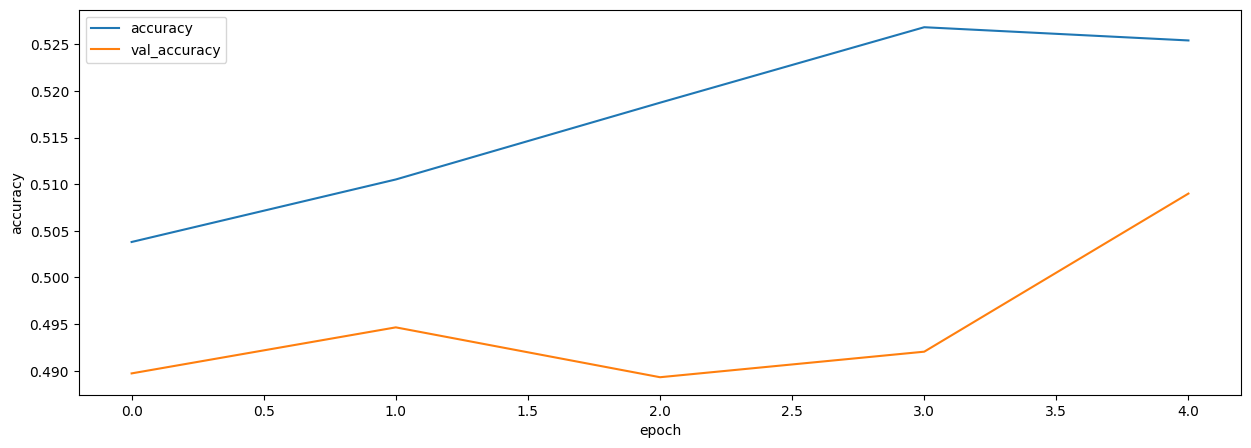

In [13]:
plot_history(history, metric='accuracy')

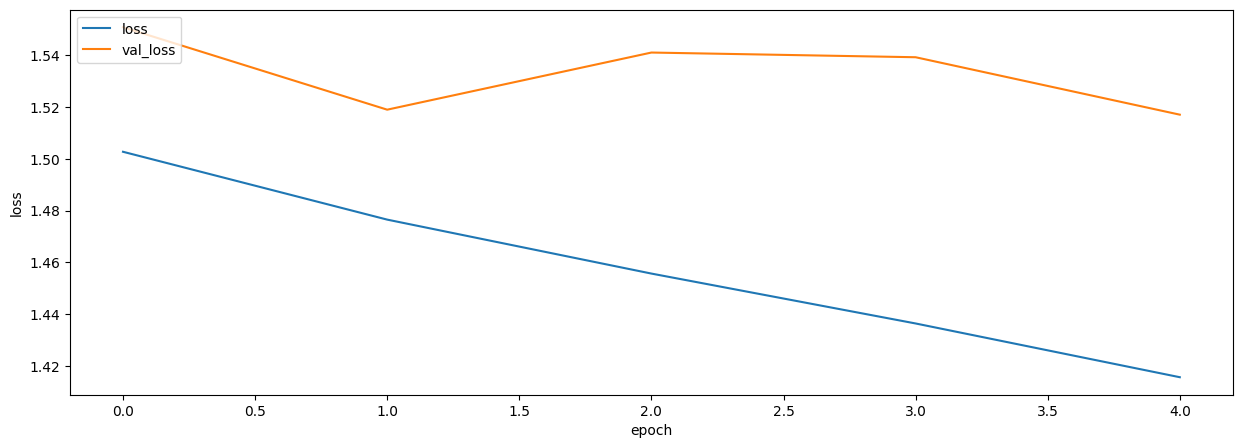

In [14]:
plot_history(history, metric='loss')

In [15]:
epochs = 5
model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name='accuracy')
        ])
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/5


W0000 00:00:1714831510.426454     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5509 - loss: 1.3507

W0000 00:00:1714831647.909041     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 173s 292ms/step - accuracy: 0.5509 - loss: 1.3507 - val_accuracy: 0.5260 - val_loss: 1.4471
Epoch 2/5
  1/562 ━━━━━━━━━━━━━━━━━━━━ 32:00 3s/step - accuracy: 0.5909 - loss: 1.2400

W0000 00:00:1714831677.497522     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5575 - loss: 1.3389

W0000 00:00:1714831812.760569     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


562/562 ━━━━━━━━━━━━━━━━━━━━ 165s 288ms/step - accuracy: 0.5575 - loss: 1.3389 - val_accuracy: 0.5188 - val_loss: 1.4587
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 285ms/step - accuracy: 0.5606 - loss: 1.3213 - val_accuracy: 0.5286 - val_loss: 1.4359
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 285ms/step - accuracy: 0.5626 - loss: 1.3169 - val_accuracy: 0.5334 - val_loss: 1.4322
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 160s 285ms/step - accuracy: 0.5616 - loss: 1.3136 - val_accuracy: 0.5267 - val_loss: 1.4321


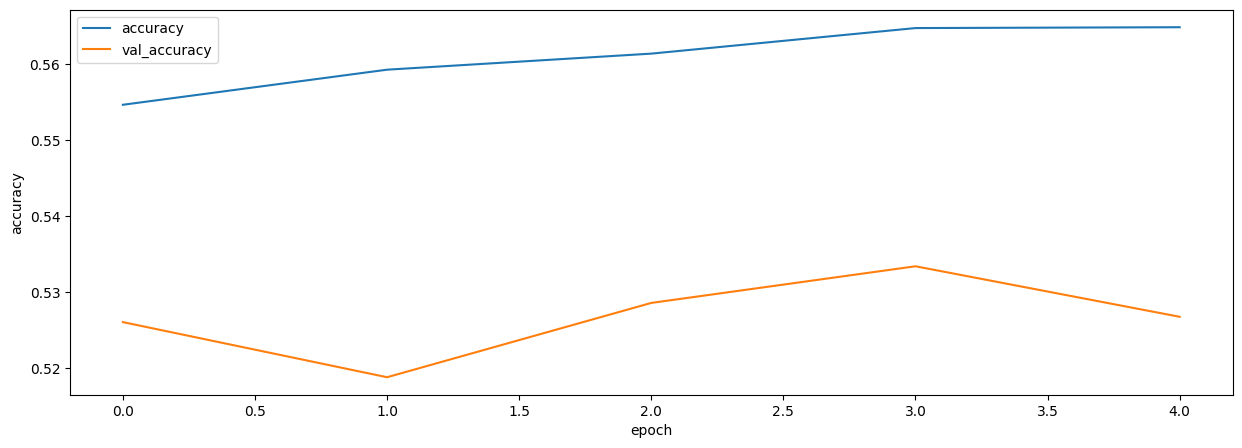

In [16]:
plot_history(history, metric='accuracy')

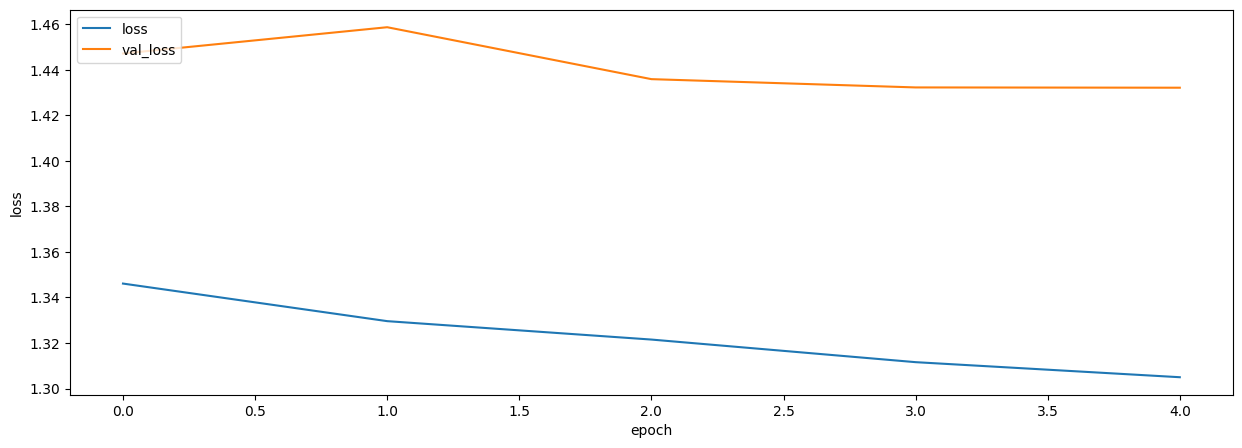

In [17]:
plot_history(history, metric='loss')

In [18]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 377ms/step - accuracy: 0.5227 - loss: 1.4370
Accuracy: 0.5260976552963257
Loss: 1.4193341732025146


W0000 00:00:1714832374.140758     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  1/121 ━━━━━━━━━━━━━━━━━━━━ 6:18 3s/step

W0000 00:00:1714832377.422625     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


121/121 ━━━━━━━━━━━━━━━━━━━━ 32s 239ms/step


W0000 00:00:1714832406.083751     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


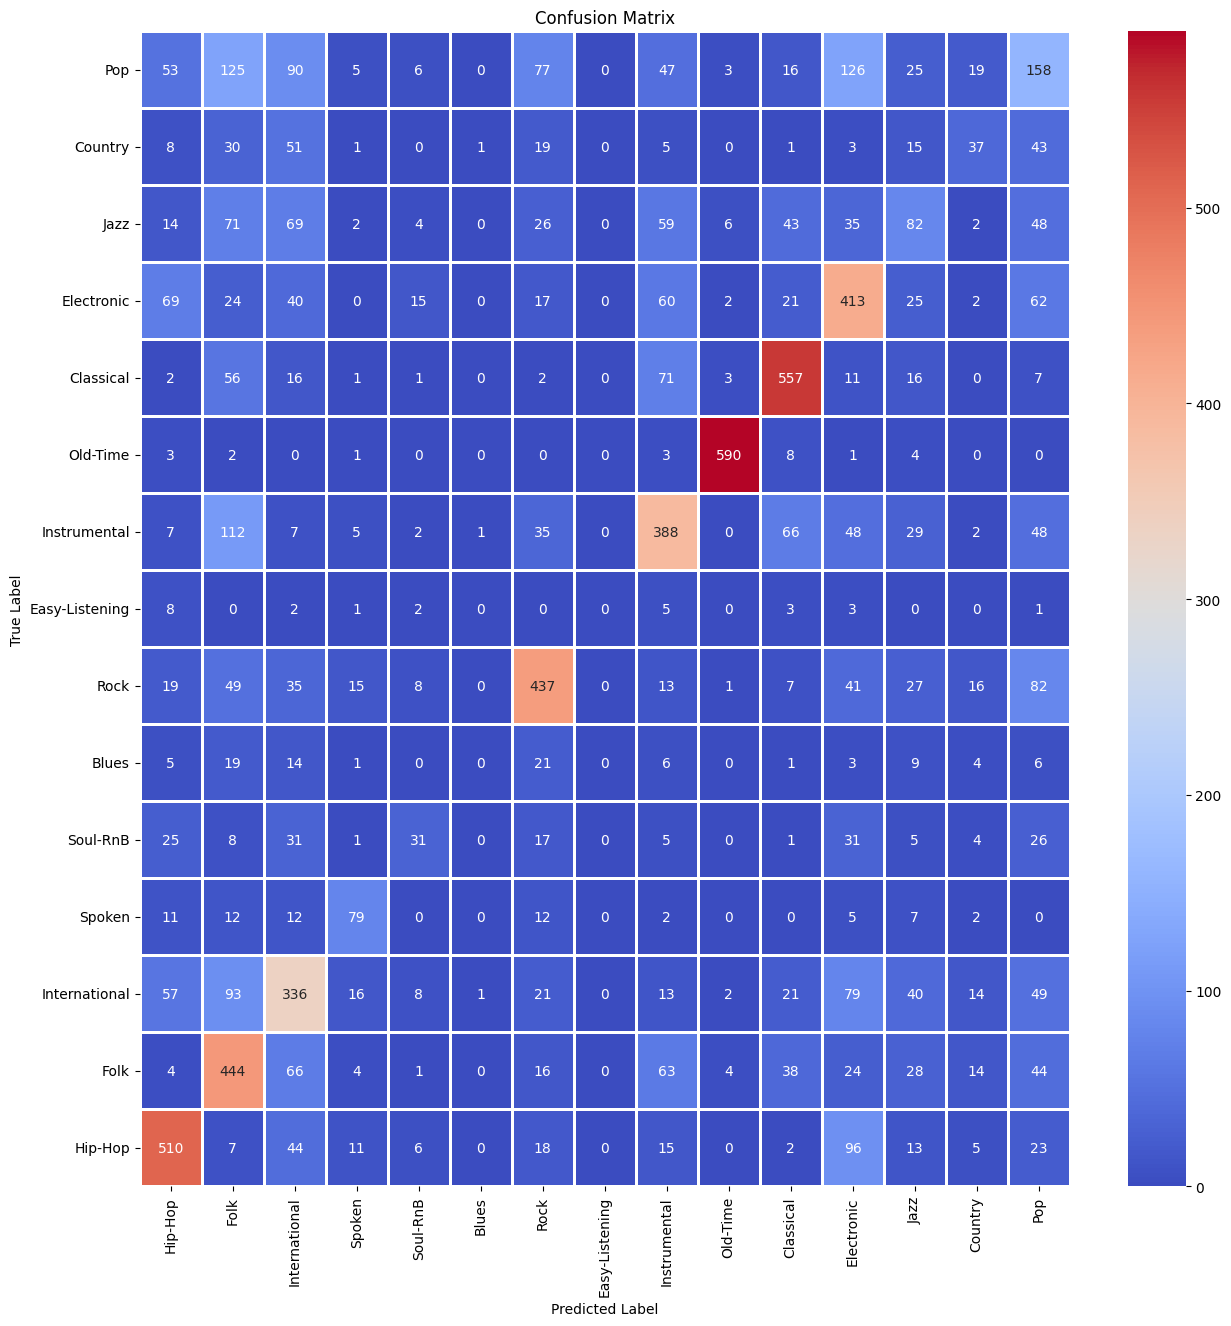

              precision    recall  f1-score   support

           0       0.64      0.68      0.66       750
           1       0.42      0.59      0.49       750
           2       0.41      0.45      0.43       750
           3       0.55      0.56      0.55       142
           4       0.37      0.17      0.23       185
           5       0.00      0.00      0.00        89
           6       0.61      0.58      0.60       750
           7       0.00      0.00      0.00        25
           8       0.51      0.52      0.52       750
           9       0.97      0.96      0.96       612
          10       0.71      0.75      0.73       743
          11       0.45      0.55      0.49       750
          12       0.25      0.18      0.21       461
          13       0.31      0.17      0.22       214
          14       0.26      0.21      0.23       750

    accuracy                           0.53      7721
   macro avg       0.43      0.42      0.42      7721
weighted avg       0.51   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))